# Gauss-Newton for XRD

In [12]:
from XRDXRFutils import GaussNewton,DataXRD,SpectraXRD,DatabaseXRD,PhaseList
from matplotlib.pyplot import xlim,ylim,xlabel,ylabel,legend,plot,fill_between,imshow,subplots,sca
from numpy import prod,array,minimum,maximum,log,zeros,trapz
from multiprocessing import Pool

### loading data

In [2]:
path = '/home/zdenek/Projects/pyMaXRDXRF/M491/ProfiloXRD/'

spectra = SpectraXRD().from_file(path + 'Frame1600.dat')
spectra.opt = [-1186.6, 1960.3, 51]

data = DataXRD().load_h5(path + 'data.h5')
data.opt = [-1186.6, 1960.3, 51]

database = DatabaseXRD().read_cifs('/home/zdenek/Projects/XRDXRFutils/Database')

lazurite = database['Lazurite'][0]
hydrocerussite = database['Hydrocerussite'][0]
cinnabar = database['Cinnabar'][0]
barite = database['Barite'][0]
spinel = database['Spinel'][0]
calcite = database['Calcite'][0]

phases = PhaseList([hydrocerussite,lazurite,cinnabar,barite,spinel,calcite])

Loading: /home/zdenek/Projects/pyMaXRDXRF/M491/ProfiloXRD/data.h5


In [3]:
class PhaseSearch():
    def __init__(self,phases,spectra):
        self.spectra = spectra
        self.intensity = spectra.intensity
        
        self.g_list = [GaussNewton(phase,spectra) for phase in phases]
        
        for g in self.g_list:
            g.opt = self.g_list[0].opt
        
    def minimize_gamma(self,n=4):
        for g in self.g_list:
            for i in range(n):
                g.minimize_gamma()
                
    def overlap_area(self):
        return array([g.overlap_area() for g in self.g_list])
    
    def loss(self):
        return array([g.loss() for g in self.g_list])
    
    def select(self):
        idx = self.overlap_area().argmax()
        selected = self.g_list[idx]
        
        self.idx = idx
        self.selected = selected
        
        return selected
    
    def theta_correction(self,n=4):
        for i in range(n):
            self.select().calibration()
            
    def search(self):
        
        self.minimize_gamma()
        self.select()

        self.theta_correction()
        self.minimize_gamma()
        
        return self

Text(0, 0.5, 'relative intensity')

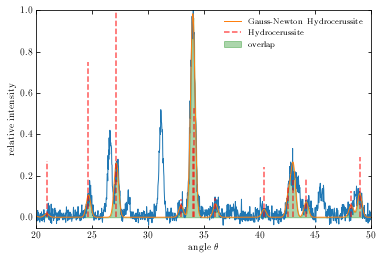

In [4]:
%matplotlib inline

phase_search = PhaseSearch(phases,spectra)

phase_search.minimize_gamma()
phase_search.select()

phase_search.theta_correction()
phase_search.minimize_gamma()

g = phase_search.select()

g.plot_spectra(lw=1)
g.plot('-',label='Gauss-Newton %s'%g.label,lw=1)
g.phase.plot('r',alpha=0.66)

fill_between(g.theta,g.overlap(),color='g',alpha=0.33,label='overlap')

legend(frameon=False)
ylim(-0.05,1)
xlim(20,50)
xlabel(r'angle $\theta$')
ylabel(r'relative intensity')

In [5]:
data2 = data.data[::2,::2,:]
data4 = data.data[::4,::4,:]

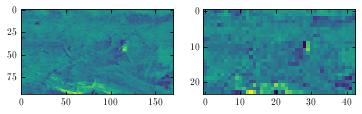

In [6]:
fig,ax = subplots(1,2)
ax[0].imshow(data.data.mean(-1))
ax[1].imshow(data4.mean(-1))

In [7]:
%%time
phase_map = []
for a in data.data.reshape(-1,1280):
    
    spectra = spectra.from_array(a)
    phase_search = PhaseSearch(phases,spectra)
    
    phase_map += [phase_search]

CPU times: user 17 s, sys: 108 ms, total: 17.1 s
Wall time: 17.1 s


In [8]:
%%time
def f(x):
    x.search()
    return x

with Pool(48) as p:
    result = p.map(f,phase_map)

CPU times: user 14.9 s, sys: 2.23 s, total: 17.1 s
Wall time: 2min 1s


Text(0, 0.5, 'relative intensity')

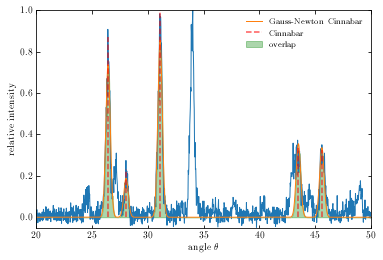

In [9]:
%matplotlib inline

g = result[20*80].select()

g.plot_spectra(lw=1)
g.plot('-',label='Gauss-Newton %s'%g.label,lw=1)
g.phase.plot('r',alpha=0.66)

fill_between(g.theta,g.overlap(),color='g',alpha=0.33,label='overlap')

legend(frameon=False)
ylim(-0.05,1)
xlim(20,50)
xlabel(r'angle $\theta$')
ylabel(r'relative intensity')

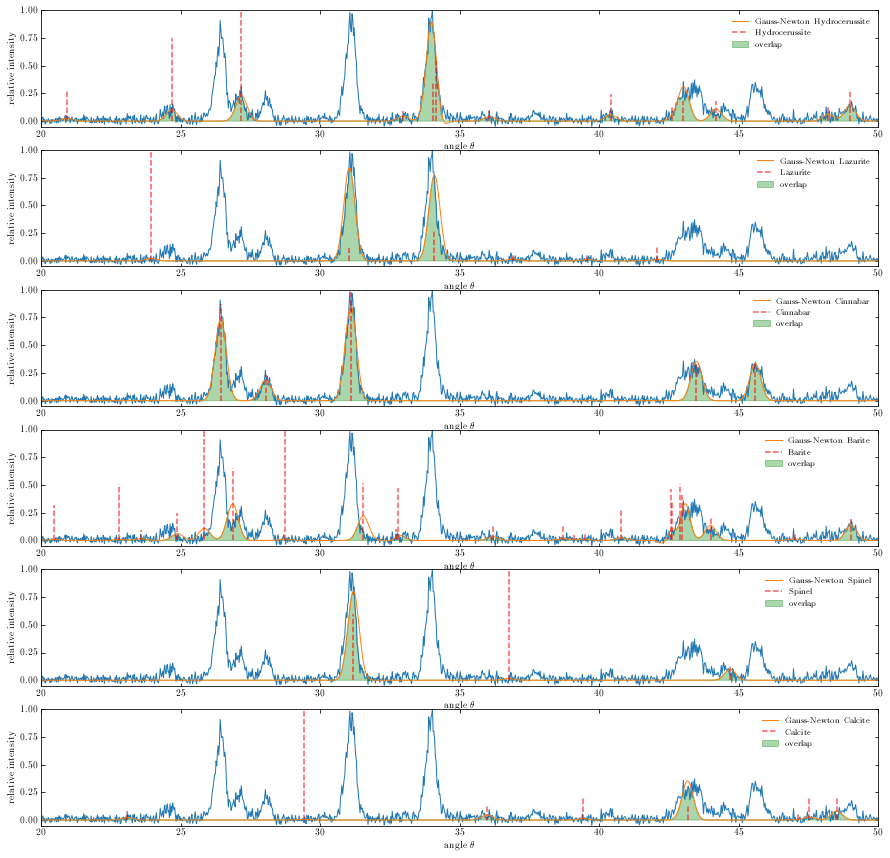

In [10]:
g_list = result[20*80].g_list
fig,ax = subplots(len(g_list),1,figsize=(15,15))
                  
for i,g in enumerate(g_list):
    
    sca(ax[i])
    
    g.plot_spectra(lw=1)
    g.plot('-',label='Gauss-Newton %s'%g.label,lw=1)
    g.phase.plot('r',alpha=0.66)

    fill_between(g.theta,g.overlap(),color='g',alpha=0.33,label='overlap')

    legend(frameon=False)
    ylim(-0.05,1)
    xlim(20,50)
    xlabel(r'angle $\theta$')
    ylabel(r'relative intensity')

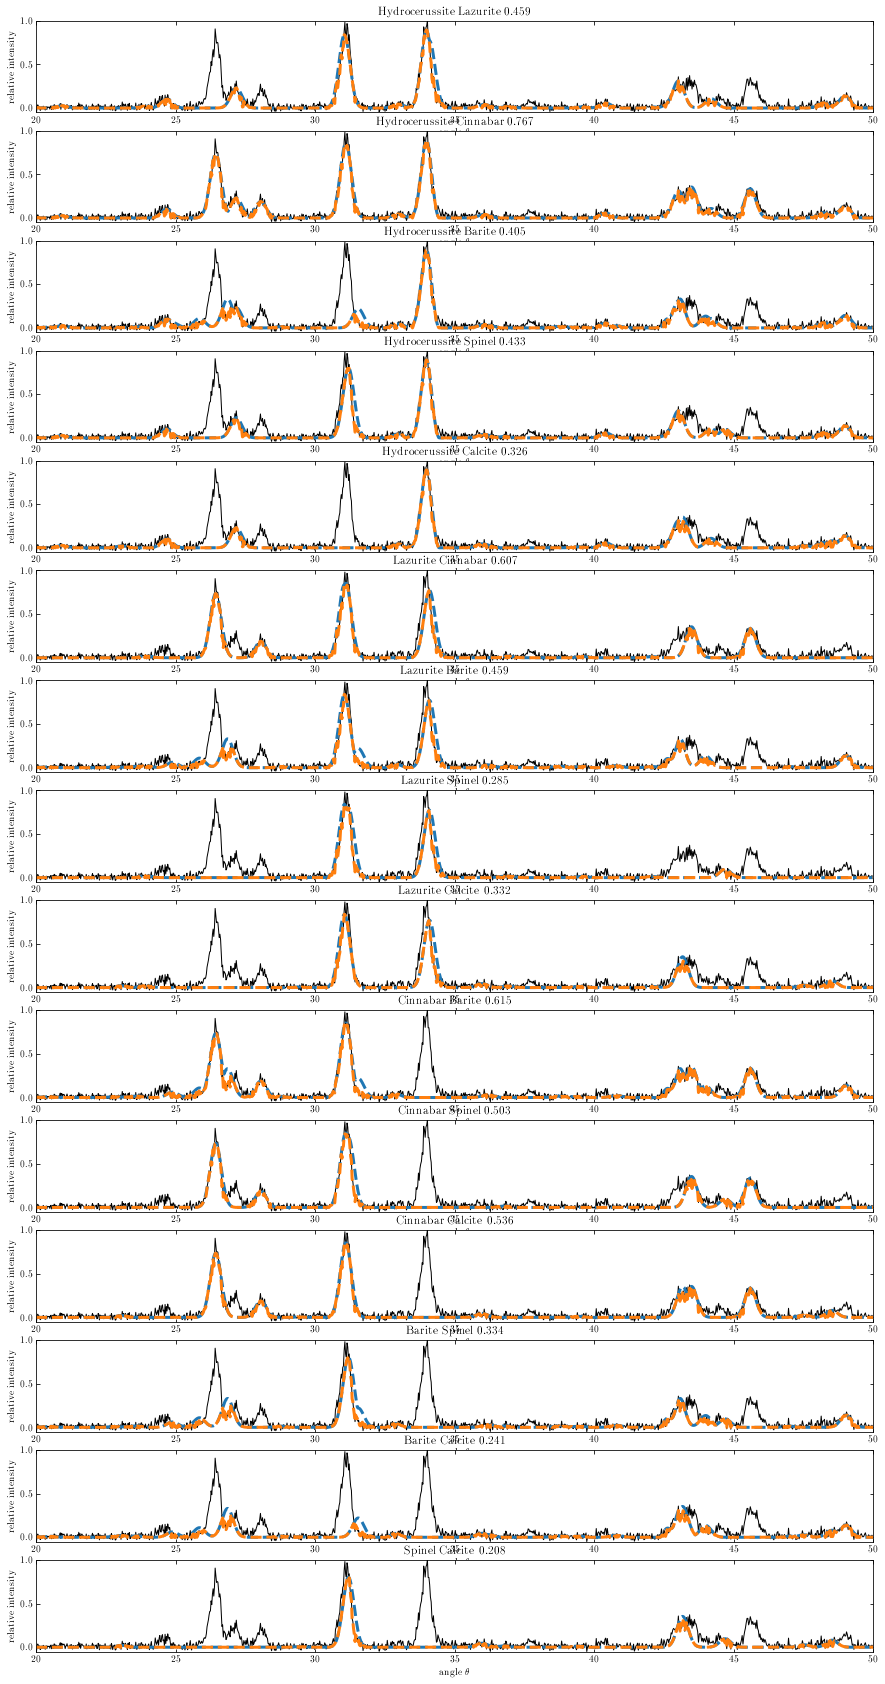

In [24]:
r = result[20*80]

g_list = r.g_list
n = int(len(g_list)*(len(g_list)-1)/2)

fig,ax = subplots(n,1,figsize=(15,30))

A = zeros((6,6))

k = 0
for i,ga in enumerate(g_list):
    for j,gb in enumerate(g_list[i+1:]):
        
        sca(ax[k])       
        c = maximum(ga.z(),gb.z())
        d = minimum(c,ga.intensity)
        d[d<0] = 0
        ss = ga.intensity.copy()
        ss[ss<0] = 0
        ss = trapz(ss)
        dd = trapz(d)
        #print(dd,ss,dd/ss)
        
        A[i,i+j+1] = dd/ss
        
        ax[k].plot(ga.theta,ga.intensity,'k',lw=1)
        ax[k].plot(gb.theta,c,'--',lw=3)
        ax[k].plot(gb.theta,d,'--',lw=3)

        #ax[k].legend(frameon=False)
        ax[k].set_title('%s %s %.3lf'%(ga.label,gb.label,dd/ss))
        ax[k].set_ylim(-0.05,1)
        ax[k].set_xlim(20,50)
        ax[k].set_xlabel(r'angle $\theta$')
        ax[k].set_ylabel(r'relative intensity')
                
        k += 1

In [76]:
A = zeros((6,6))

k = 0
for i,ga in enumerate(g_list):
    for j,gb in enumerate(g_list):
            
        c = maximum(ga.z(),gb.z())
        d = minimum(c,ga.intensity)
        d[d<0] = 0
        ss = ga.intensity.copy()
        ss[ss<0] = 0
        ss = trapz(ss)
        dd = trapz(d)
        
        A[i,j] = dd/ss
        
A

array([[0.30213149, 0.45935291, 0.7667094 , 0.40547185, 0.43317587,
        0.32634399],
       [0.45935291, 0.25941746, 0.60682427, 0.45915672, 0.2847269 ,
        0.33209416],
       [0.7667094 , 0.60682427, 0.48682365, 0.61509216, 0.50295435,
        0.53565105],
       [0.40547185, 0.45915672, 0.61509216, 0.21833975, 0.33356522,
        0.2410335 ],
       [0.43317587, 0.2847269 , 0.50295435, 0.33356522, 0.13482454,
        0.20840387],
       [0.32634399, 0.33209416, 0.53565105, 0.2410335 , 0.20840387,
        0.0737714 ]])

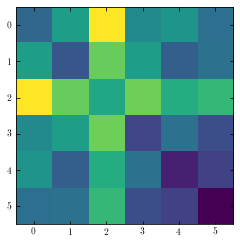

In [106]:
imshow(A)

In [109]:
from numpy.linalg import eig,svd,qr,cholesky,pinv,eigvals,det
eigvals(A),det(A)

(array([ 2.54011617, -0.45994258, -0.25315235, -0.21702066, -0.05086711,
        -0.08382518]),
 -0.00027368552113372674)

In [15]:
idx = array([r.idx for r in result]).reshape(95,170)
a = array([r.selected.opt[0] for r in result])
s = array([r.selected.opt[1] for r in result])

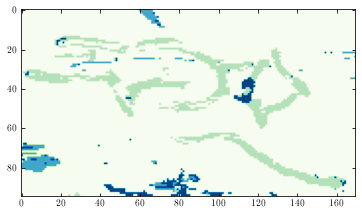

In [16]:
%matplotlib inline
imshow(idx,cmap='GnBu')

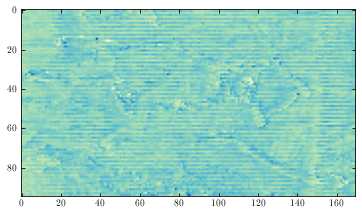

In [17]:
%matplotlib inline
imshow(a.reshape(95,170),cmap='GnBu')

-1186.6787372522056 1960.8514337987385


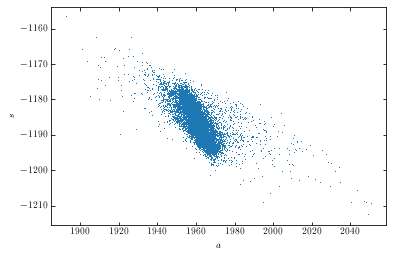

In [18]:
%matplotlib inline

plot(s,a,',')
ylabel(r'$s$')
xlabel(r'$a$')
print(a.mean(),s.mean())

In [138]:
%%time
area = array([r.overlap_area() for r in result])
loss = array([r.loss() for r in result])
ss = array([trapz(r.spectra.intensity) for r in result])

CPU times: user 46.1 s, sys: 1.52 ms, total: 46.1 s
Wall time: 46.1 s


In [58]:
area = area.reshape(95,170,-1)
loss = loss.reshape(95,170,-1)
ss = ss.reshape(95,170)

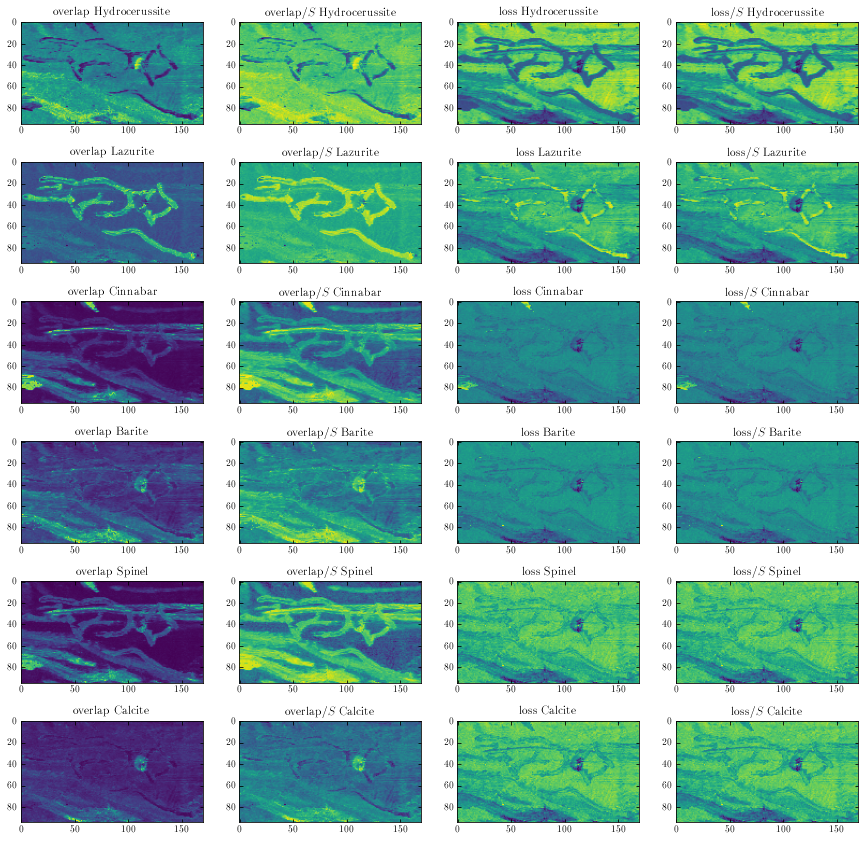

In [61]:
fig,ax = subplots(6,4,figsize=(15,15))

for i,g in enumerate(g_list):
    
    ax[i,0].imshow(area[:,:,i])
    ax[i,1].imshow(log(area[:,:,i]/ss))
    ax[i,2].imshow(-log(loss[:,:,i]))
    ax[i,3].imshow(-log(loss[:,:,i]/ss))
    
    ax[i,0].set_title(r'overlap %s'%g.label)
    ax[i,1].set_title(r'overlap/$S$ %s'%g.label)
    ax[i,2].set_title(r'loss %s'%g.label)
    ax[i,3].set_title(r'loss/$S$ %s'%g.label)